In [105]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import math as m

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


[0.2754883980755993, 0.29797745638343376, 0.32178662689556164, 0.3469421471701038, 0.37346561322369265, 0.40137347337588225, 0.4306765257183155, 0.46137942448775526, 0.4934802009174041, 0.5269698043844107, 0.5618316698556503, 0.5980413177517382, 0.6355659923943858, 0.6743643451689734, 0.7143861684178301, 0.7555721858764972, 0.7978539051726967, 0.8411535375246401, 0.8853839893019412, 0.9304489295504337, 0.9762429369349622, 1.0226517288265398, 1.0695524744586231, 1.1168141932096176, 1.164298238144612, 1.2118588639795682, 1.2593438776279768, 1.3065953684664862, 1.3534505144264413, 1.3997424589974512, 1.4453012532323612, 1.4899548558858717, 1.5335301839169762, 1.575854204753514, 1.6167550609699255, 1.6560632173803898, 1.6936126200113049, 1.729241856000544, 1.7627953031854016, 1.7941242579940955, 1.823088030252469, 1.8495549936613618, 1.873403580991851, 1.8945232134837142, 1.9128151545131904, 1.928193278313136, 1.9405847453735208, 1.9499305771121989, 1.9561861234723026, 1.959321418259044, 1

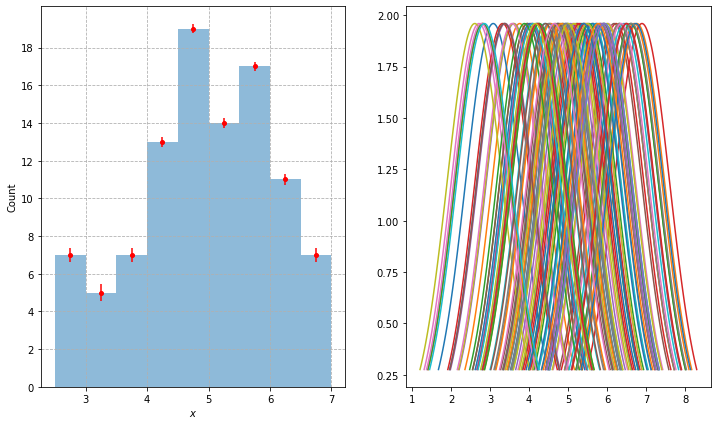

In [137]:
npr.seed(2053854)

sig=1.0
mu=5.
x=npr.normal(loc=mu, scale=sig, size=100)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
p=0.5
histo=ax1.hist(x, bins=np.arange((x.min()//p)*p,(x.max()//p)*p+2*p,p), alpha=0.5)
ax1.set_ylabel('Count')
ax1.set_xlabel('$x$')
n=histo[0]
b=[i+p/2 for i in histo[1][:-1]]
n_err=[1/m.sqrt(i) for i in n]
ax1.set_yticks(np.arange(0,int(n.max()),2))
ax1.errorbar(b, n, yerr=n_err, fmt='o', ms=4, c='r')
ax1.grid(linestyle='--')


def gauss(vec,i):
    xi=vec[i]
    s=1.06*vec.std()*len(vec)**(-1/5)
    x=np.linspace(xi-3*s, xi+3*s,100)
    y=[]
    for xl in x:
        y.append(1/(s*m.sqrt(2*m.pi))*m.e**(-(xl-xi)**2)/(2*s**2))
    return x, y

xx,yy=gauss(x,5)

print(yy)

for i in range(len(x)):
    xx,yy=gauss(x,i)
    ax2.plot(xx,yy)
    

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 14:38:20--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-17 14:38:20--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucf08e6905d1af2d3896db082fc4.dl.dropboxusercontent.com/cd/0/inline/BDXix2_dqdgaay0CqpUasoeq-d7qojUHdcsmMO4LSt4qx-6aIfFdyTse5ykuTp1AKTZzWHqB83UcrULRU6e9PqpgyW2Ud6gq_BVV1oIDp8Jfng/file# [segue]
--2020-11-17 14:38:21--  https://ucf08e6905d1af2d3896db082fc4.dl.dropboxusercontent.com/cd/0/inline/BDXix2_dqdgaay0CqpUasoeq-d7qojUHdcsmMO4LSt4qx-6aIfFdyTse5ykuTp1AKTZzWHqB83Ucr

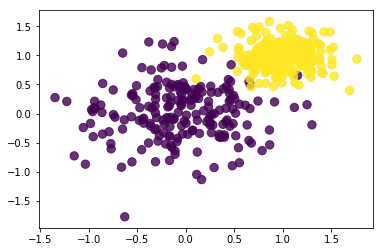

In [18]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot